In [105]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import noisereduce as nr

import dataprocessing

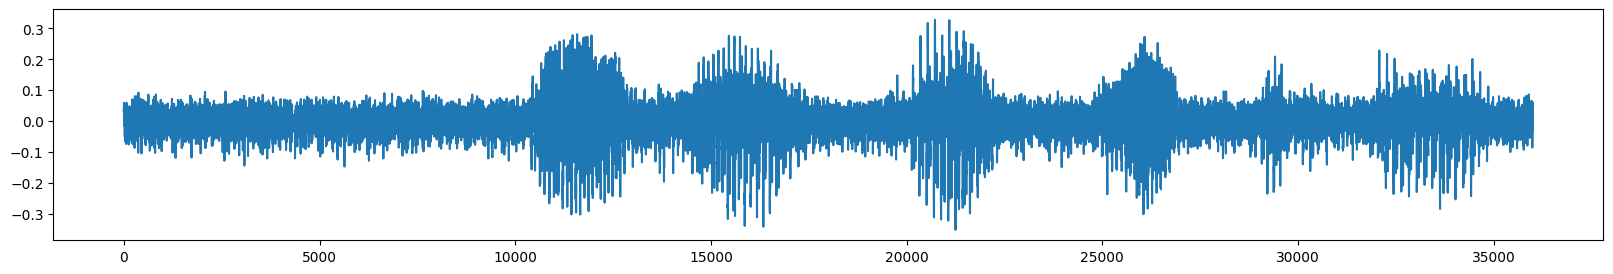

In [106]:
data, samplerate = sf.read('Y.wav')
seconds_to_plot = 1.5
indices_to_plot = int(seconds_to_plot * samplerate)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(data[:indices_to_plot])
plt.show()

noise_seconds = 0.4
noise_indices = int(noise_seconds * samplerate)
noise_data = data[:noise_indices]
dataprocessing.resave('Y.wav', 0, noise_indices, 'Y_noise.wav')

In [107]:
def dataToEnergy(data, sr, frame_time, frame_shift):
    frameWidth = int(frame_time * sr)
    frameShift = int(frame_shift * frameWidth)

    frameCount = int(data.size / (frameWidth - frameShift)) - 1
    print(f'{frameWidth=}')
    print(f'{frame_shift=}')
    print(f'{frameCount=}')

    E = [0.0] * frameCount
    sh = 0
    df = frameWidth - frameShift
    for i in range(frameCount):
        En = 0
        for j in range(frameWidth):
            sn = float(data[j + sh] ** 2)
            En = En + sn

        E[i] = En / frameWidth
        sh = sh + df

    return E

frameWidth=480
frame_shift=0.5
frameCount=39
E_noise_max=1.63e-03


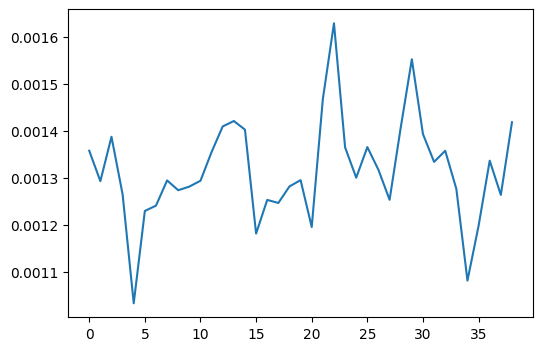

In [108]:
frame_time = 20e-3
frame_shift = 0.5


E = dataToEnergy(noise_data, samplerate, frame_time, frame_shift)
E_noise_max = np.max(E)
print(f'{E_noise_max=:.2e}')
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(E)
plt.show()

In [109]:
def VAD(data, sr, frame_time, frame_shift, noise_frame_end, eTh):
    frameWidth = int(frame_time * sr)
    frameShift = int(frame_shift * frameWidth)

    frameCount = int(data.size / (frameWidth - frameShift)) - 1

    maxY = np.max(data)
    df = frameWidth - frameShift
    E = [0] * frameCount
    sh = 0
    for i in range(frameCount):
        En = 0

        for j in range(frameWidth):
            sn = float(data[j + sh] ** 2)
            En = En + sn

        E[i] = En / frameWidth
        sh = sh + df

    if noise_frame_end > 0:
        ePorog = 0
        for j in range(0, noise_frame_end):
            if ePorog < E[j]:
                ePorog = E[j]

        print(ePorog)
        ePorog = ePorog * 5
    else:
        ePorog = eTh

    st_jcounter = False
    dj_len = 0
    tickData = []
    vadData = [0] * frameCount
    for j in range(frameCount):

        if E[j] <= ePorog:
            vadData[j] = 0
        else:
            vadData[j] = 1

        if (j > 0):
            if (vadData[j-1] < vadData[j]):
                st_jcounter = False
                if (j - dj_len >= 0):
                    tickData.append((j - dj_len) * df)
                else:
                    tickData.append(0 * df)
            elif ( vadData[j-1] > vadData[j]):
                st_jcounter = True
                dj = 0
                tickData.append(j * df)
            else:
                if st_jcounter:
                    dj+=1
                    if dj == dj_len:
                        tickData.append(j * df)
                        st_jcounter = False
                        dj = 0
        # if (j == frameCount - 1) and st_jcounter and (dj > 0):
        #     tickData.append(j * df)



    return vadData, tickData


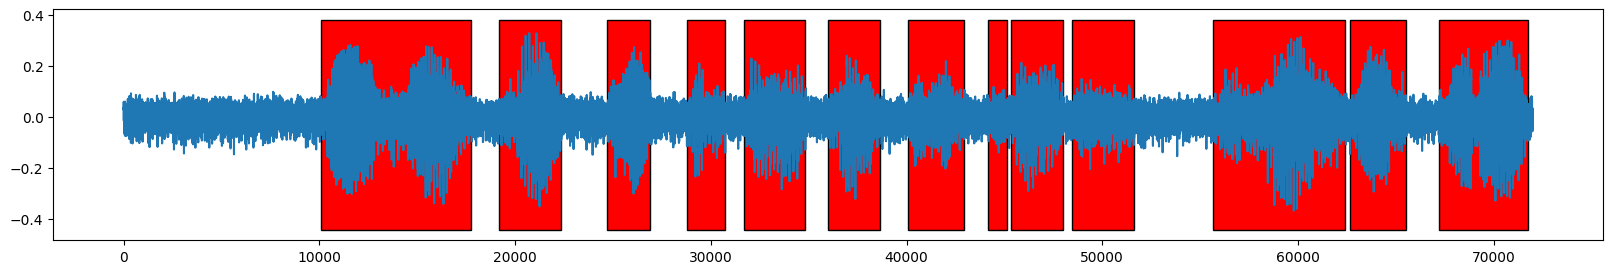

In [110]:
vadData, tickData = VAD(data, samplerate, frame_time, frame_shift, noise_frame_end=0, eTh= E_noise_max)

seconds_to_plot = 3
indices_to_plot = int(seconds_to_plot * samplerate)
ticks = []
for tick in tickData:
    if tick > indices_to_plot:
        break

    ticks.append(tick)

plt.rcParams["figure.figsize"] = (20,3)
fig, ax = plt.subplots()
for i in range(int(len(ticks) / 2)):
    left_tick = ticks[2*i]
    right_tick = ticks[2*i + 1]
    rect = Rectangle((left_tick, np.min(data)), width=right_tick - left_tick, height = np.max(data) - np.min(data), facecolor='r', linewidth=1, edgecolor='k')
    ax.add_patch(rect)
    
ax.plot(data[:indices_to_plot])
plt.show()

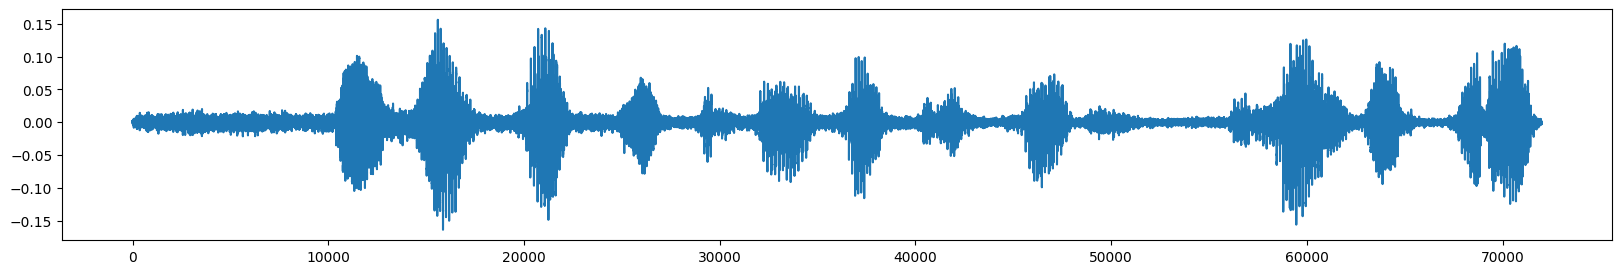

In [129]:
filtered_data = nr.reduce_noise(y=data, sr=samplerate, y_noise=noise_data, time_constant_s=10)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_data[:indices_to_plot])
plt.show()

sf.write('Y_filtered11.wav', filtered_data, samplerate)

In [114]:
def digital_filter(data, alpha):
    N = len(data)
    y = np.zeros(N)
    y[0] = data[0] / np.sqrt(1 - alpha**2)
    for n in range(1, N):
        y[n] = alpha * y[n-1] + np.sqrt(1 - alpha**2) * data[n]
    
    return y

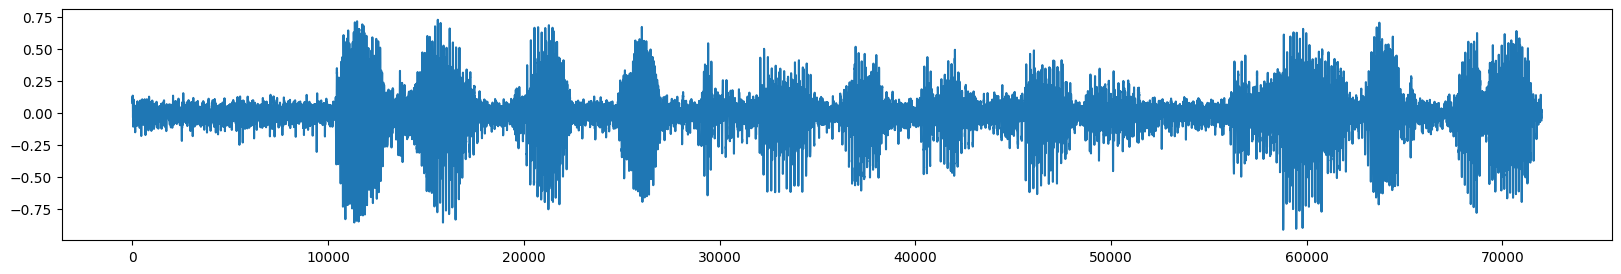

In [128]:
filtered_data2 = digital_filter(data, 0.9)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_data2[:indices_to_plot])
plt.show()

sf.write('Y_filtered2.wav', filtered_data2, samplerate)